In [1]:
import json
import glob

from itertools import product

import numpy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = "../urbangrammar_samba/spatial_signatures/ai/gb_*_shuffled/json/"

In [3]:
results = glob.glob(path + "*")

In [4]:
names = [i[64:-5] + "_" + i[47:49] for i in results]

In [5]:
with open(results[0], "r") as f:
    result = json.load(f)

In [6]:
accuracy = pd.DataFrame(columns=["global"] + result["meta_class_names"], index=pd.MultiIndex.from_product([names, ["train", "val", "secret"]]))

In [9]:
for r in results[:-1]:
    with open(r, "r") as f:
        result = json.load(f)
    
    accuracy.loc[(result["model_name"]+ "_" + r[47:49], "train")] = [result["perf_model_accuracy_train"]] + result["perf_within_class_accuracy_train"]
    accuracy.loc[(result["model_name"]+ "_" + r[47:49], "val")] = [result["perf_model_accuracy_val"]] + result["perf_within_class_accuracy_val"]
    accuracy.loc[(result["model_name"]+ "_" + r[47:49], "secret")] = [result["perf_model_accuracy_secret"]] + result["perf_within_class_accuracy_secret"]


In [8]:
accuracy

global   centres periphery  \
efficientnet_pooling_256_5_16 train   0.540909  0.716571  0.469743   
                              val     0.532293    0.7104    0.4596   
                              secret  0.537547  0.733733  0.453333   
efficientnet_pooling_256_5_64 train   0.825237  0.999681  0.978119   
                              val     0.599028  0.876449  0.346168   
                              secret  0.537702  0.698892  0.311963   
efficientnet_pooling_256_5_32 train   0.631566  0.912743    0.5622   
                              val     0.561333  0.754533    0.4884   
                              secret  0.561562  0.747511  0.494267   

                                     Countryside agriculture Wild countryside  \
efficientnet_pooling_256_5_16 train                 0.500086         0.732914   
                              val                   0.490533         0.728267   
                              secret                  0.4912         0.730533   
efficientnet_pooling_256_5_64 train                 0.608968         0.857752   
                              val                   0.480374         0.777009   
                              secret                 0.46972         0.779252   
efficientnet_pooling_256_5_32 train                   0.5084         0.826914   
                              val                   0.469467         0.796667   
                              secret                0.474133         0.800533   

                                     Urban buffer  
efficientnet_pooling_256_5_16 train      0.285229  
                              val        0.272667  
                              secret     0.278933  
efficientnet_pooling_256_5_64 train      0.681666  
                              val         0.51514  
                              secret     0.511028  
efficientnet_pooling_256_5_32 train      0.347571  
                              val          0.2976  
                              secret     0.312933

<AxesSubplot:title={'center':'validation'}>

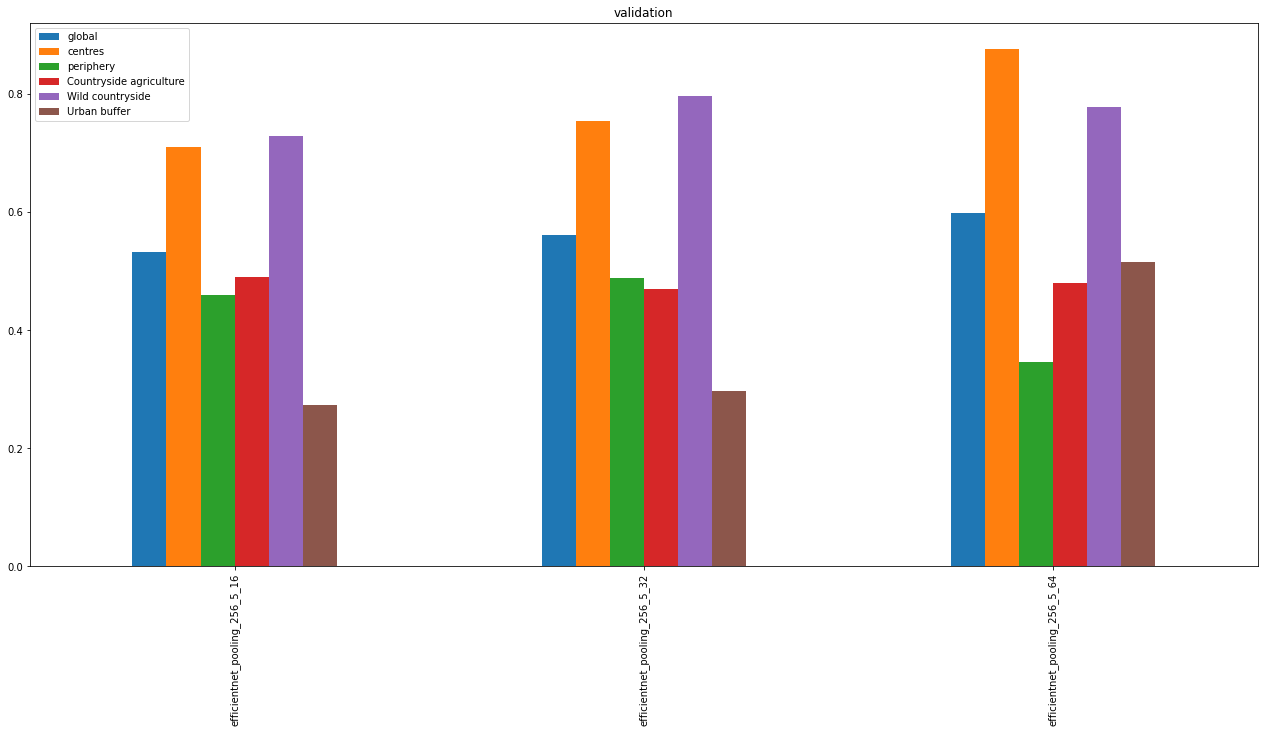

In [9]:
accuracy.xs('val', level=1).sort_index().plot.bar(figsize=(22, 10), title="validation")

Notes:
1. overall accuracy is unimpressive
2. in princple, larger chips have a better performance but there's a big but - if you don't do massive aggregation, you don't have enough data for urban signature types
3. we're not horrible in predicting centres and wild countryside
4. urban buffer is a challenging class due to the amout of greenery
5. periphery and countryside are somewhere in between

6. we're good in predicting urban vs non-urban (two blocks on the confusion matrices)
7. we're not putting urban buffer to countryside classes (conceptually) but the neural net is (empirically)
8. 32 is empircally a better way of approximating signatures than 64 - when there is a space to fit 64x64 chip, it usually covers some adjacent green space because other signature types are too small to fit enough chips
    - this could be mitigating by preferring chips with the larger number of intersections with underlying ET cells
        - count the number of intersections, sort and get N chips with the largest number. That way you limit the number of chips from large ET cells covering greenery.

- ordered confusion matrix has a pattern similar to co-occurency matrix of singature types (empirical paper)

To-do:
- prediction on 12 classes (combine only urbanity) and analyse the confusion matrix to know which to combine
- we can try two parallel models, one with a single chip and another one with 3x3 chips around (or a few sampled) and merge before the end with a Dense to combine them [spatial lag]

Next steps:
1. prediction on 12 classes using 32x32 chips
    - deirive aggregation 
2. pipeline for John's data to get way more chips
3. replicate 32x32 training with the new chips
    - both 12 classes and aggregation
4. consider elimination of chips from large green ET cells (see note 8)
5. consider parallel model

Timeline:
- Revisions by end of Feb
- Empirical paper submitted by end of Apr
- AI experiments by end of Apr
- AI paper submitted by end of June

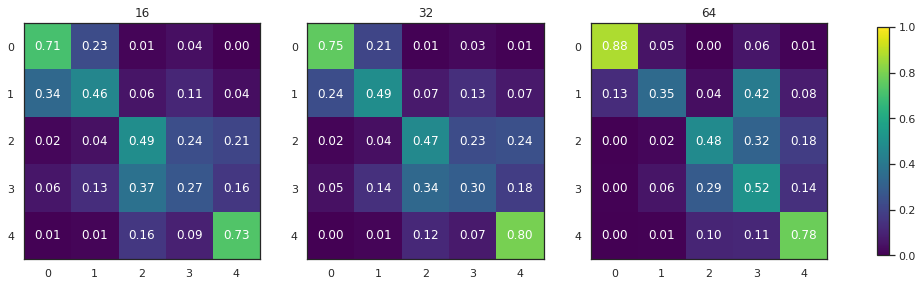

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, r in enumerate(sorted(results)):
    with open(r, "r") as f:
        result = json.load(f)
    a = numpy.array(result['perf_confusion_val'])
    a = a / a.sum(axis=1)[:, numpy.newaxis]
    a = pd.DataFrame(a).iloc[[0,1,2,4,3],[0,1,2,4,3]].values
    im = axs[i].imshow(a, cmap="viridis", vmin=0, vmax=1)
    for k, j in product(range(5), range(5)):
        axs[i].text(j, k, "{:.2f}".format(a[k, j]),
                       ha="center", va="center", color="w")
    axs[i].set_title(result['meta_chip_size'])
#     add labels
fig.colorbar(im, ax=axs[:], shrink=.7)

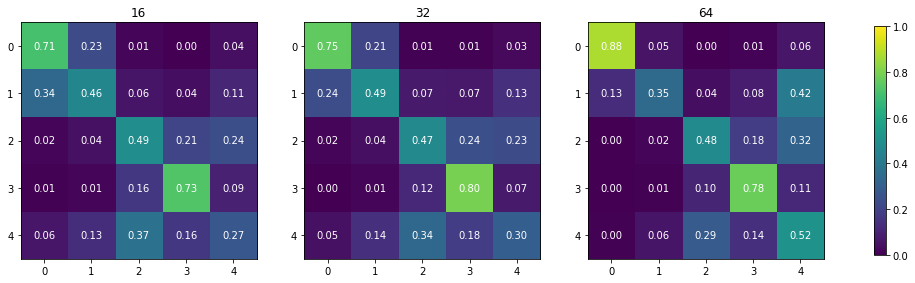

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, r in enumerate(sorted(results)):
    with open(r, "r") as f:
        result = json.load(f)
    a = numpy.array(result['perf_confusion_val'])
    a = a / a.sum(axis=1)[:, numpy.newaxis]
    im = axs[i].imshow(a, cmap="viridis", vmin=0, vmax=1)
    for k, j in product(range(5), range(5)):
        axs[i].text(j, k, "{:.2f}".format(a[k, j]),
                       ha="center", va="center", color="w")
    axs[i].set_title(result['meta_chip_size'])
fig.colorbar(im, ax=axs[:], shrink=.7)

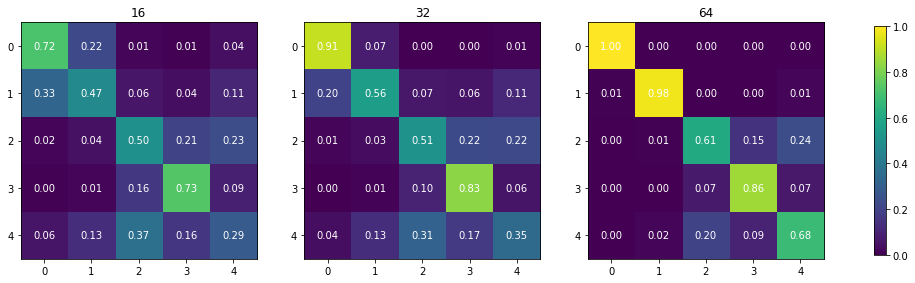

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, r in enumerate(sorted(results)):
    with open(r, "r") as f:
        result = json.load(f)
    a = numpy.array(result['perf_confusion_train'])
    a = a / a.sum(axis=1)[:, numpy.newaxis]
    im = axs[i].imshow(a, cmap="viridis", vmin=0, vmax=1)
    for k, j in product(range(5), range(5)):
        axs[i].text(j, k, f"{a[k, j]:.2f}",
                       ha="center", va="center", color="w")
    axs[i].set_title(result['meta_chip_size'])
fig.colorbar(im, ax=axs[:], shrink=.7)

## 12 classes

In [8]:
results

['../urbangrammar_samba/spatial_signatures/ai/gb_16_shuffled/json/efficientnet_pooling_256_5.json',
 '../urbangrammar_samba/spatial_signatures/ai/gb_64_shuffled/json/efficientnet_pooling_256_5.json',
 '../urbangrammar_samba/spatial_signatures/ai/gb_32_shuffled/json/efficientnet_pooling_256_5.json',
 '../urbangrammar_samba/spatial_signatures/ai/gb_32_shuffled/json/efficientnet_pooling_256_12.json']

In [10]:
with open(results[3], "r") as f:
    result = json.load(f)

In [11]:
result["meta_class_names"] = [
        "Urbanity", 
        "Dense residential neighbourhoods",
        "Connected residential neighbourhoods",
        "Dense urban neighbourhoods",
        "Accessible suburbia",
        "Open sprawl",
        "Warehouse/Park land",
        "Gridded residential quarters",
        "Disconnected suburbia",
        "Countryside agriculture", 
        "Wild countryside", 
        "Urban buffer"
    ]

In [12]:
accuracy = pd.DataFrame(columns=["global"] + result["meta_class_names"], index=pd.Index(["train", "val", "secret"]))

In [14]:
accuracy.loc["train"] = [result["perf_model_accuracy_train"]] + result["perf_within_class_accuracy_train"]
accuracy.loc["val"] = [result["perf_model_accuracy_val"]] + result["perf_within_class_accuracy_val"]
accuracy.loc["secret"] = [result["perf_model_accuracy_secret"]] + result["perf_within_class_accuracy_secret"]

<AxesSubplot:title={'center':'validation'}>

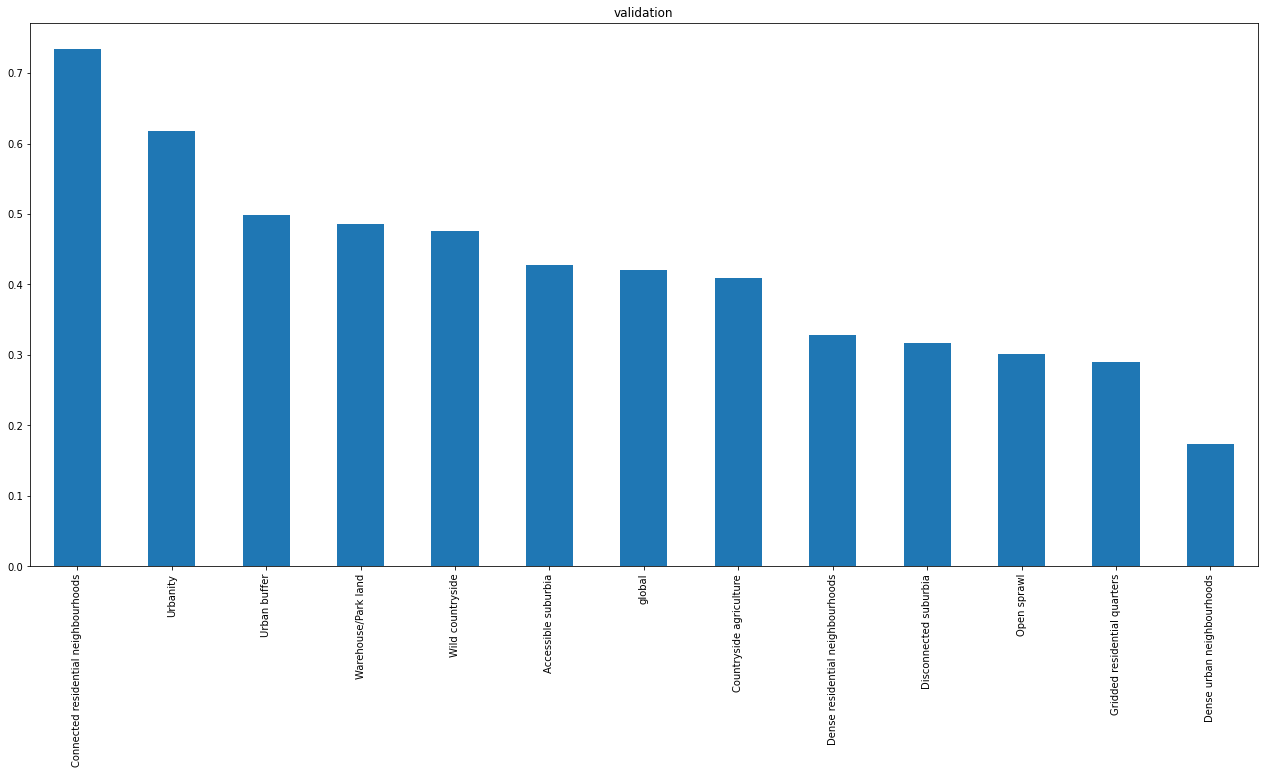

In [15]:
accuracy.loc['val'].sort_values(ascending=False).plot.bar(figsize=(22, 10), title="validation")

In [32]:
a = numpy.array(result['perf_confusion_val'])
a = a / a.sum(axis=1)[:, numpy.newaxis]

In [35]:
order = numpy.array([0, 3, 1, 2, 7, 4, 8, 5, 6, 11, 9, 10], dtype=int)
a = pd.DataFrame(a).iloc[order, order].values

([<matplotlib.axis.YTick at 0x7efc65b62610>,
 [Text(0, 0, 'Urbanity'),
  Text(0, 1, 'Dense urban neighbourhoods'),
  Text(0, 2, 'Dense residential neighbourhoods'),
  Text(0, 3, 'Connected residential neighbourhoods'),
  Text(0, 4, 'Gridded residential quarters'),
  Text(0, 5, 'Accessible suburbia'),
  Text(0, 6, 'Disconnected suburbia'),
  Text(0, 7, 'Open sprawl'),
  Text(0, 8, 'Warehouse/Park land'),
  Text(0, 9, 'Urban buffer'),
  Text(0, 10, 'Countryside agriculture'),
  Text(0, 11, 'Wild countryside')])

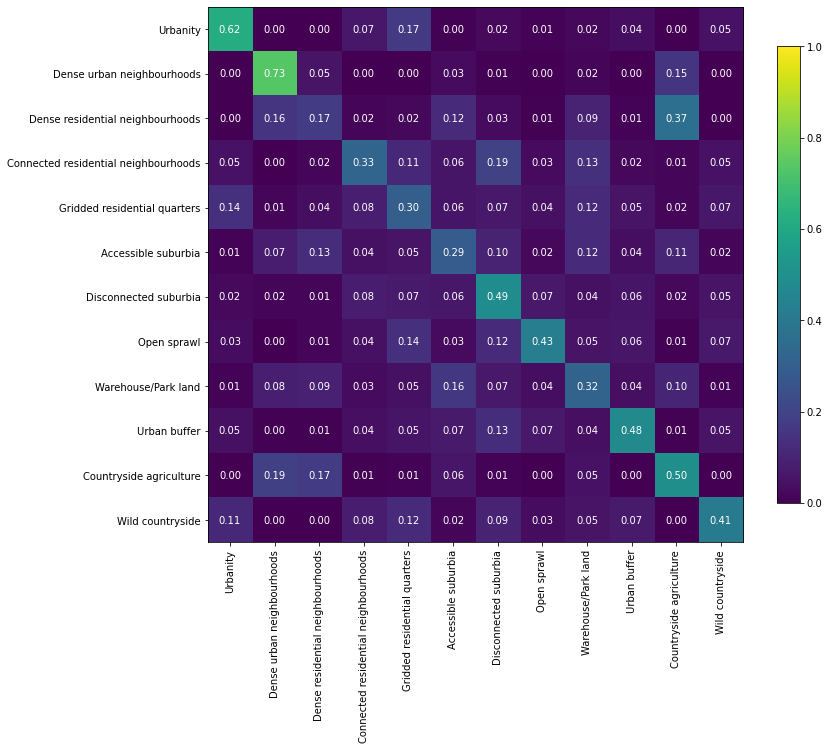

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))


im = plt.imshow(a, cmap="viridis", vmin=0, vmax=1)
for k, j in product(range(12), range(12)):
    plt.text(j, k, "{:.2f}".format(a[k, j]),
                   ha="center", va="center", color="w")
fig.colorbar(im, ax=ax, shrink=.7)
plt.xticks(range(12),numpy.array(result["meta_class_names"])[order], rotation=90)
plt.yticks(range(12),numpy.array(result["meta_class_names"])[order])

([<matplotlib.axis.YTick at 0x7fee9883fe80>,
 [Text(0, 0, 'Urbanity'),
  Text(0, 1, 'Dense residential neighbourhoods'),
  Text(0, 2, 'Connected residential neighbourhoods'),
  Text(0, 3, 'Dense urban neighbourhoods'),
  Text(0, 4, 'Accessible suburbia'),
  Text(0, 5, 'Open sprawl'),
  Text(0, 6, 'Warehouse/Park land'),
  Text(0, 7, 'Gridded residential quarters'),
  Text(0, 8, 'Disconnected suburbia'),
  Text(0, 9, 'Countryside agriculture'),
  Text(0, 10, 'Wild countryside'),
  Text(0, 11, 'Urban buffer')])

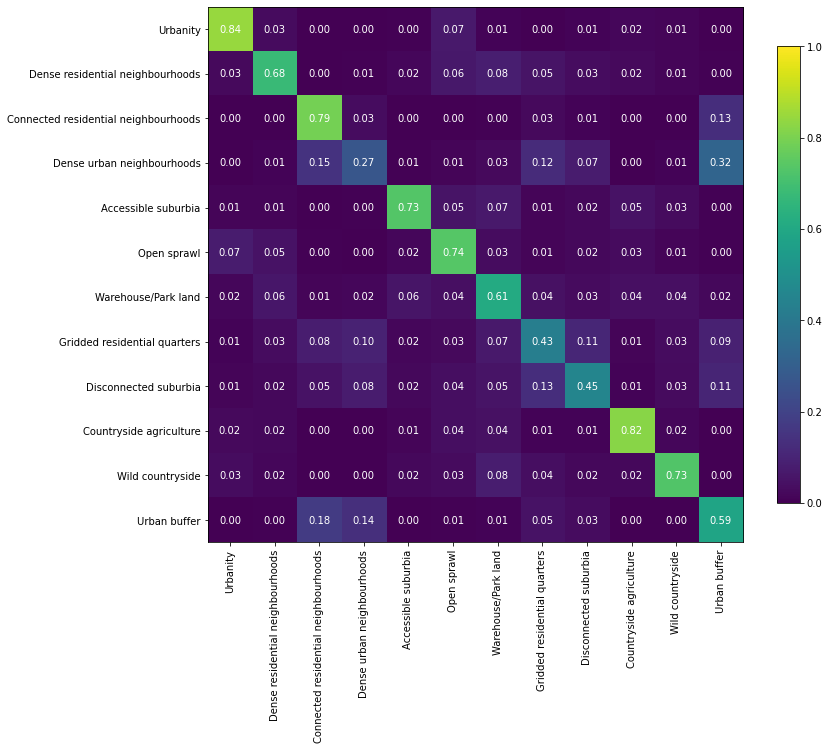

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))

a = numpy.array(result['perf_confusion_train'])
a = a / a.sum(axis=1)[:, numpy.newaxis]
im = plt.imshow(a, cmap="viridis", vmin=0, vmax=1)
for k, j in product(range(12), range(12)):
    plt.text(j, k, "{:.2f}".format(a[k, j]),
                   ha="center", va="center", color="w")
fig.colorbar(im, ax=ax, shrink=.7)
plt.xticks(range(12),result["meta_class_names"], rotation=90)
plt.yticks(range(12),result["meta_class_names"])